# Imports 

In [26]:
import os, sys
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
import pickle
import sklearn.decomposition
import sklearn.cluster
import matplotlib.cm
import importlib
from matplotlib import animation
from IPython.display import HTML

# Data loading
## Spike extraction

In [27]:
data_root = '/home/mano/Documents/Profesional Projects/Raster_tuto/spont'
video_root = '/home/mano/Documents/Profesional Projects/Raster_tuto/spont/cam/'

dbs = {'mouse_name': 'TX60', 'date': '2020_10_20', 'exp': '2', 'cam': ['0', '1']}



In [28]:
dat = np.load(os.path.join(data_root, 'spont_2cam_%s_%s.npz'%
                  (dbs['mouse_name'], dbs['date'])))

spks = dat['spks'].astype(np.float32)

Exploring the `npz` data structure:

In [29]:
dat.files

['spks', 'tcam', 'ypos', 'xpos', 'tneural', 'run']

In [30]:
spks.shape

(42568, 23185)

n_features (neurons) x n_samples

## spike normalization

In [31]:
spks -= spks.mean(axis=1)[:,np.newaxis]
spks /= ((spks**2).mean(axis=1)**0.5)[:,np.newaxis]

# Rastermap fit

In [32]:
sys.path.insert(0, '/home/mano/Documents/Profesional Projects/RasterMap')
from rastermap import mapping

In [33]:
RM_model = mapping.Rastermap(smoothness=1, 
                           n_clusters=100, 
                           n_PCs=128, 
                           ts=0.9,
                           time_lag_window=0,
                           grid_upsample=10,
                           n_splits=0).fit(spks, normalize=False) # (we've already normalized)

n_PCs = 128 computed, time 26.58
landmarks computed and embedded, time 41.30
grid upsampled, time 44.35


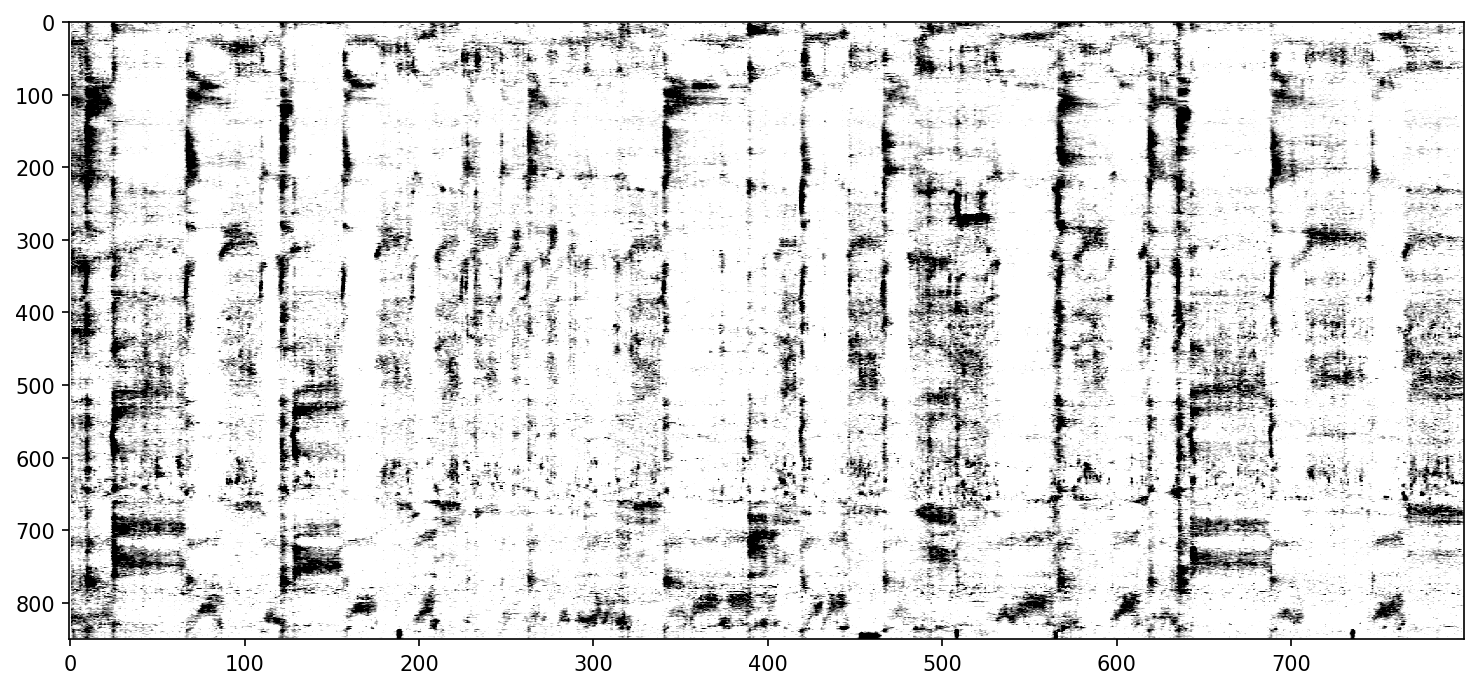

In [34]:
from scipy.stats import zscore
plt.figure(figsize=(12,12), dpi=150)
xmin=0
xmax=xmin+800
plt.subplot(2,1,1)
plt.imshow(zscore(RM_model.X_embedding[:,xmin:xmax], axis=1), vmin=0, vmax=2, cmap='gray_r', aspect='auto')

In [39]:
RM_model.X_embedding.shape

(851, 23185)

n_clusters x timepoints (its already binned in bins of 50 neurons)

## Needs work -v 

In [44]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

n_comps = 851 # chose to match rastermap output dimension 
pca_128 = PCA(n_components=n_comps).fit(spks)
spk_pc = (pca_128.components_.T * pca_128.singular_values_).T


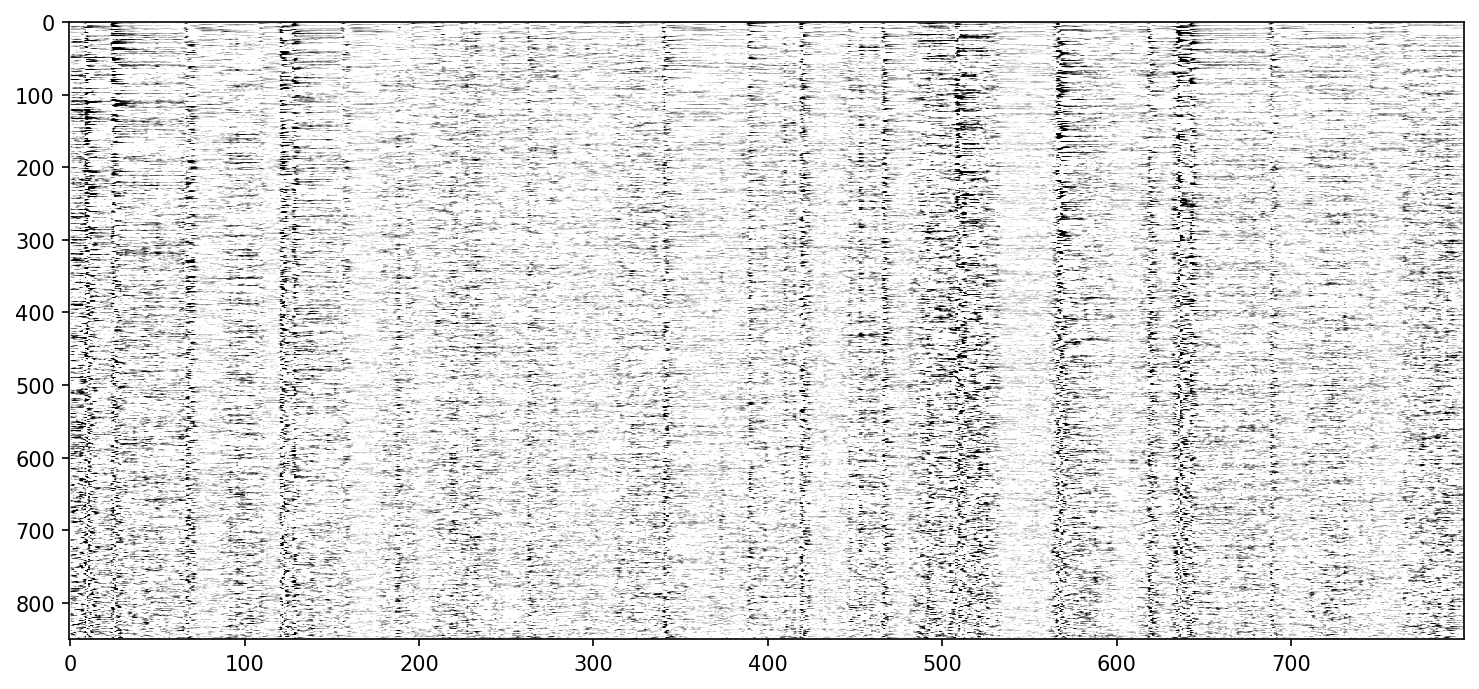

In [45]:
plt.figure(figsize=(12,12), dpi=150)
plt.subplot(2,1,1)
plt.imshow(zscore(spk_pc[:,xmin:xmax], axis=1), vmin=0, vmax=2, cmap='gray_r', aspect='auto')

In [47]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(spk_pc)


In [82]:
clusters = [100,200,300,400]
labels = []
for ncluster in clusters:
    kmeans = KMeans(n_clusters=ncluster, random_state=0).fit(spk_pc)
    labels.append(kmeans.labels_)
labels = np.asarray(labels)

In [87]:
sort_idx=np.argsort(labels[2])

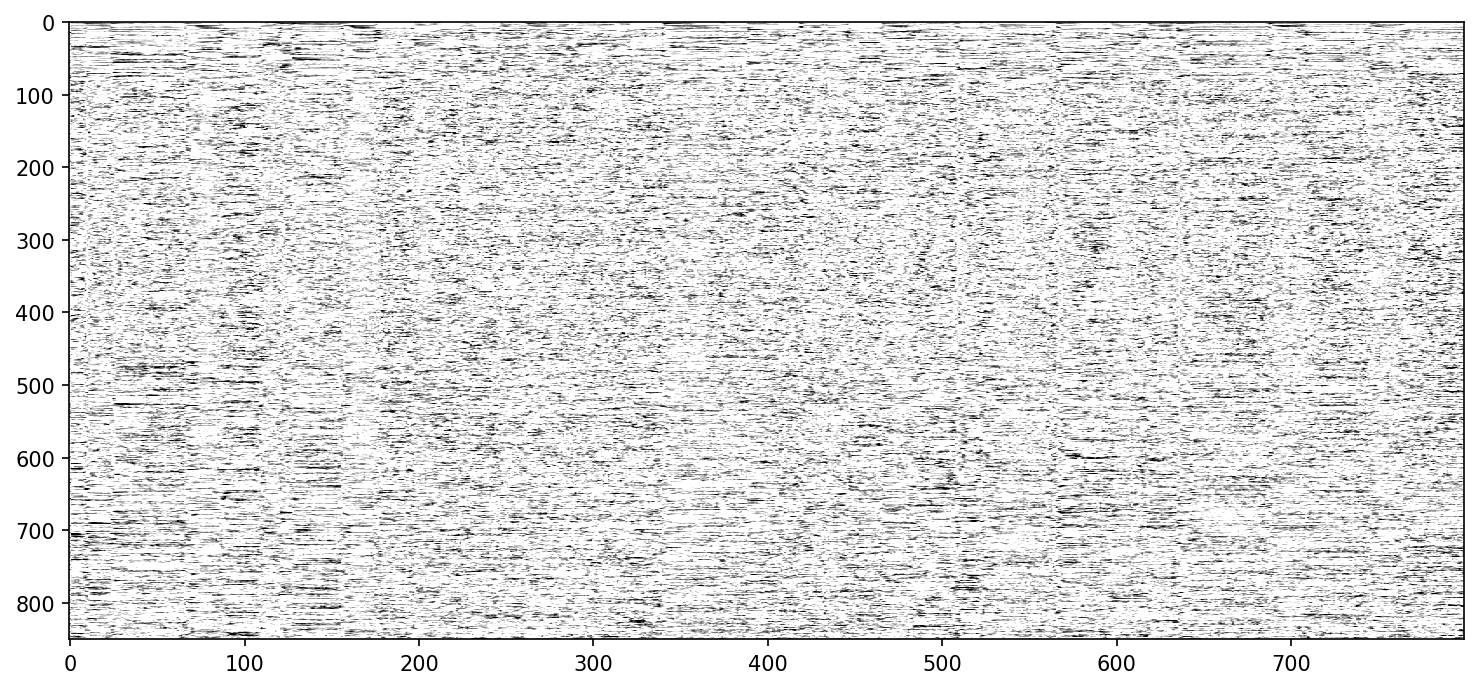

In [88]:
pc_sort_knn=zscore(spk_pc[sort_idx,xmin:xmax])

plt.figure(figsize=(12,12), dpi=150)
plt.subplot(2,1,1)
plt.imshow(zscore(pc_sort_knn, axis=1), vmin=0, vmax=2, cmap='gray_r', aspect='auto')